In [1]:
import os
import pandas as pd
import numpy as np
from glob import glob
import nibabel as nib
from nilearn.plotting import plot_img, plot_stat_map, view_img, plot_prob_atlas
from nilearn.regions import connected_label_regions
from nilearn.glm.first_level.hemodynamic_models import spm_hrf
from nilearn.image import concat_imgs, mean_img, index_img, smooth_img
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm import threshold_stats_img
import matplotlib.pyplot as plt
from nilearn.plotting import plot_design_matrix
from nilearn.interfaces.fmriprep import load_confounds_strategy
from nilearn.plotting import plot_roi
from nilearn.maskers import NiftiMapsMasker, NiftiSpheresMasker
from scipy.interpolate import interp1d
import seaborn as sns

# Homemade functions

In [2]:
def Merge(dict1, dict2):

    # create a new dictionary by merging the items of the two dictionaries using the union operator (|)
    merged_dict = dict(dict1.items() | dict2.items())
    
    # return the merged dictionary
    return merged_dict

def merge_dictionaries(dict1, dict2):
    merged_dict = dict1.copy()
    merged_dict.update(dict2)
    return merged_dict

In [3]:
# Define a function to invert scores if needed. 
def transform_scores(score, invert):
    if(invert == True):
        if(score == 1):  
            return 4
        elif(score == 2):  
            return 3
        elif(score == 3):  
            return 2
        elif(score == 4):  
            return 1
        elif(score == "1"):  
            return 4
        elif(score == "2"):  
            return 3
        elif(score == "3"):  
            return 2
        elif(score == "4"):  
            return 1
        elif(score == "None"):
            return 0
        else: 
            return "Something went wrong here!"
    else:
        if(score == "1"):
            return 1
        elif(score == "2"):
            return 2
        elif(score == "3"):
            return 3
        elif(score == "4"):
            return 4
        elif(score == "None"):
            return 0
        else:
            return "Something went wrong here!"

In [4]:
# Percent signal change .
def get_psc(timecourse):

   # Get number of ROIs and data points in timecourse.
   roi_num = timecourse.shape[1]
   data_length = timecourse.shape[0]

   # Copy timecourse into new array.
   psc_timecourse = np.zeros(timecourse.shape)

   # Warning for empty arrays. 
   if(roi_num ==0):
      print("Watch out, this array is empty!")

   # Loop through every ROI and derive the psc. 
   for id in range(roi_num):

      current_roi_avg = np.mean(timecourse[:, id], axis=0)

      for idx in range(data_length):

         # Formula to get percent signal change -> ((point-avg)/avg)*100.
         psc_timecourse[idx, id] = ((timecourse[idx, id] - current_roi_avg)/ current_roi_avg)*100

   return psc_timecourse

In [5]:
def process_events_data(run_dataframe):

    proccesed_events_df = pd.DataFrame(columns={"Trailer", "Type", "Onset", "Duration", "Offset", "W_score", "A_score", "F_score"}) 

    # Initial fixation 12 sec (TR=6).
    in_fix = 12

    # Time it take subjects to complete questionnaire 12 sec (TR=6). 
    questionnaire_duration = 12

    # All trailers last 30 sec (TR=15). 
    trailer_duration = 30

    # Initialize this variable, though it will change through each iteration of the loop.
    trailer_onset = 0

    # Run a for loop for each row in the df. 
    for id in range(run_dataframe.shape[0]):

        # Get trailer label and separate them accroding to their type. 
        trailer_name = run_dataframe["label"][id]
        trailer_type = "Horror" if "h" in run_dataframe["label"][id] else "Comedy"

        # This onsets don't work, so I need to re-calculate them
        traile_iti = run_dataframe["trial_ITI"][id]
        
        # For the first run add the initial fixation time to the calculation of the first trailer onset. 
        # After the first run, calculate onset by adding previous traile onset, questionnaire duration, and trial iti.
        if (id == 0):
            trailer_onset += in_fix
        else:
            trailer_onset += trailer_duration + questionnaire_duration + traile_iti

        # Calculate trailer onset. 
        trailer_offset = trailer_onset + 30 

        """ 
        For the questionnaire scores, as I understood it. If they were not inverted (["scale_flip"] == 0), then 
        the lower the score the stronger the response. If they were inverted (["scale_flip"] == 1), the higher the 
        score the stronger the response.
        """
        # Fix bug with the scores, some come as strings and some as integers.
        # try:
        #     trailer_watch_score = run_dataframe["exp_Watch.keys"][id].astype(int)
        #     trailer_arousal_score = run_dataframe["exp_Arousal.keys"][id].astype(int)
        #     trailer_feel_score = run_dataframe["exp_Feel.keys"][id].astype(int)
        # except(ValueError):
        #     trailer_watch_score = int(run_dataframe["exp_Watch.keys"][id])
        #     trailer_arousal_score = int(run_dataframe["exp_Arousal.keys"][id])
        #     trailer_feel_score = int(run_dataframe["exp_Feel.keys"][id])
        # except(AttributeError):
        #     trailer_watch_score = int(run_dataframe["exp_Watch.keys"][id])
        #     trailer_arousal_score = int(run_dataframe["exp_Arousal.keys"][id])
        #     trailer_feel_score = int(run_dataframe["exp_Feel.keys"][id])

        trailer_watch_score = transform_scores(run_dataframe["exp_Watch.keys"][id], False)
        trailer_arousal_score = transform_scores(run_dataframe["exp_Arousal.keys"][id], False)
        trailer_feel_score = transform_scores(run_dataframe["exp_Feel.keys"][id], False)

        # Check if scaled was flipped and put scores on the same scale. 
        # For me, the most intuitive is that the higher the score, the stronger the response. 
        if(run_dataframe["scale_flip"][id] == 0):
            #trailer_watch_score = run_dataframe["exp_Watch.keys"].apply(invert_score)[id].astype(int)
            #trailer_arousal_score = run_dataframe["exp_Arousal.keys"].apply(invert_score)[id].astype(int)
            #trailer_feel_score = run_dataframe["exp_Feel.keys"].apply(invert_score)[id].astype(int)

            # Fix bug with the scores, some come as strings and some as integers.
            trailer_watch_score = transform_scores(run_dataframe["exp_Watch.keys"][id], True)
            trailer_arousal_score = transform_scores(run_dataframe["exp_Arousal.keys"][id], True)
            trailer_feel_score = transform_scores(run_dataframe["exp_Feel.keys"][id], True)
            # try:
            #     trailer_watch_score = run_dataframe["exp_Watch.keys"][id].astype(int)
            #     trailer_arousal_score = run_dataframe["exp_Arousal.keys"][id].astype(int)
            #     trailer_feel_score = run_dataframe["exp_Feel.keys"][id].astype(int)
            # except(ValueError):
            #     trailer_watch_score = int(run_dataframe["exp_Watch.keys"][id])
            #     trailer_arousal_score = int(run_dataframe["exp_Arousal.keys"][id])
            #     trailer_feel_score = int(run_dataframe["exp_Feel.keys"][id])
            # except(AttributeError):
            #     trailer_watch_score = int(run_dataframe["exp_Watch.keys"][id])
            #     trailer_arousal_score = int(run_dataframe["exp_Arousal.keys"][id])
            #     trailer_feel_score = int(run_dataframe["exp_Feel.keys"][id])
       
        
        # Place processed data on list, add list to new dataframe, and concat to main dataframe. 
        current_row_data = [[trailer_name, trailer_type, trailer_onset, trailer_duration, trailer_offset, trailer_watch_score, trailer_arousal_score, trailer_feel_score]]
        current_row = pd.DataFrame(data=current_row_data, columns=["Trailer", "Type", "Onset", "Duration", "Offset", "W_score", "A_score", "F_score"]) 
        proccesed_events_df = pd.concat([proccesed_events_df, current_row], ignore_index=True)
        proccesed_events_df = proccesed_events_df[["Trailer", "Type", "Onset", "Offset", "Duration", "W_score", "A_score", "F_score"]]

    return proccesed_events_df

In [6]:
# Open a datasets directory. 
fd = os.open("/Users/luisalvarez/Documents/Datasets", os.O_RDONLY)

# Use os.fchdir() method to change the current dir/folder.
os.fchdir(fd)

# Safe check- Print current working directory
print("Current working dir : %s" % os.getcwd())

Current working dir : /Users/luisalvarez/Documents/Datasets


In [16]:

def getROI_PSC_timecourse(participant_num): 

    # Add code to flag if something that is not a number is passed. 

    ## 1) Load data.
    # Load relevant files for participant
    sub_run1_func_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
    sub_run2_func_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"

    sub_run1_mask_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-01_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"
    sub_run2_mask_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-02_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"

    sub_run1_events_path = "MovieData_BIDS_raw/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-01_events.csv"
    sub_run2_events_path = "MovieData_BIDS_raw/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-02_events.csv"

    sub_run1_confounds_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-01_desc-confounds_timeseries.tsv"
    sub_run2_confounds_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-01_desc-confounds_timeseries.tsv"

    # Calculate relevant parameters for GLM and ROI time-course analysis.
    func_file = nib.load(sub_run1_func_path)
    func_data = func_file.get_fdata()
    n_vols = func_data.shape[3]
    TR = 2
    n_timepoints = n_vols*TR

    # Load raw events files. 
    sub_run1_events_df = pd.read_csv(sub_run1_events_path, index_col=0)
    sub_run2_events_df = pd.read_csv(sub_run2_events_path, index_col=0)

    ## 2) Process files. 
    # Process event files. 
    sub_run1_p_events = process_events_data(sub_run1_events_df)
    sub_run2_p_events = process_events_data(sub_run2_events_df)

    # Down-sample time onsets to get vol onsets. 
    # Create array from 0 to 'n_timepoints' in steps of 1.
    time_scale = np.arange(0, n_timepoints, 1)  

    # Create array from 0 to 'n_timepoints' in steps of 2.
    vol_scale = np.arange(0, n_timepoints, TR)  

    # Get the labels of each trailer for each run. 
    run1_trailer_labels = sub_run1_p_events["Trailer"].tolist()
    run2_trailer_labels = sub_run2_p_events["Trailer"].tolist()

    # Create dictionary variable to store arrays with onset values for each trailer. 
    run1_onsets = {}
    run2_onsets = {}

    # Create a dictionary with all the onsets for each trailer in each run. 
    for id in range(len(run1_trailer_labels)):

        # Create array of zeros.
        run1_trailer_onsets = np.zeros(n_timepoints)
        run2_trailer_onsets = np.zeros(n_timepoints)

        # Get onset time. 
        run1_current_trailer_onset = sub_run1_p_events["Onset"][id]
        run2_current_trailer_onset = sub_run2_p_events["Onset"][id]

        # Assign 1 to such onset all the way til the end of the trailer (30 sec) in the array of zeros.
        # Adjust for lag: add 4 seconds at the onset and offset
        run1_trailer_onsets[int(run1_current_trailer_onset + 4):int(run1_current_trailer_onset)+ 30 + 4] = 1
        run2_trailer_onsets[int(run2_current_trailer_onset + 4):int(run2_current_trailer_onset)+ 30 + 4] = 1

        # Create resampler objects for each trailer/run of reward.
        run1_resampler = interp1d(time_scale, run1_trailer_onsets)
        run2_resampler = interp1d(time_scale, run2_trailer_onsets)

        # Create downsampled arrays for each trailer. 
        # Note this vol arrays are half the length than the time arrays.
        run1_trailer_vol_onsets = run1_resampler(vol_scale)
        run2_trailer_vol_onsets = run2_resampler(vol_scale)

        # Append/store the downsampled volumes arrays to each dictionary.
        # I'm doing it this way, so the code is more interpretable
        run1_onsets[run1_trailer_labels[id]] = run1_trailer_vol_onsets
        run2_onsets[run2_trailer_labels[id]] = run2_trailer_vol_onsets

    ## 3) Load confound data. 
    sub_run1_confounds_df = pd.read_csv(sub_run1_confounds_path, sep='\t')
    sub_run2_confounds_df = pd.read_csv(sub_run2_confounds_path, sep='\t')
    default_confounds = ["white_matter", "csf", "csf_wm",  "framewise_displacement", "dvars", "rmsd", "cosine00", "tcompcor"]
    
    cohen_confounds = ['c_comp_cor_00','c_comp_cor_01','c_comp_cor_02','w_comp_cor_00','w_comp_cor_01','w_comp_cor_02','w_comp_cor_03','w_comp_cor_04','trans_x','trans_y','trans_z','rot_x','rot_y','rot_z','trans_x_derivative1','trans_y_derivative1','trans_z_derivative1','rot_x_derivative1','rot_y_derivative1','rot_z_derivative1','trans_x_power2','trans_y_power2','trans_z_power2','rot_x_power2','rot_y_power2','rot_z_power2','trans_x_derivative1_power2','trans_y_derivative1_power2','trans_z_derivative1_power2','rot_x_derivative1_power2','rot_y_derivative1_power2','rot_z_derivative1_power2']
    #['trans_y', 'trans_x', 'trans_z', 'rot_y', 'rot_x', 'rot_z', #"global_signal", "csf", "white_matter", "csf_wm",  "framewise_displacement", "dvars"]
    #                    "white_matter", "csf", "csf_wm",  "framewise_displacement", "dvars"]

    sub_run1_motion_s_confounds = [i for i in sub_run1_confounds_df.columns if "state" in i] #"motion"
    sub_run2_motion_s_confounds = [i for i in sub_run2_confounds_df.columns if "state" in i] 

    sub_run1_motion_rot_confounds = [i for i in sub_run1_confounds_df.columns if "rot" in i] 
    sub_run2_motion_rot_confounds = [i for i in sub_run2_confounds_df.columns if "rot" in i] 

    sub_run1_motion_trans_confounds = [i for i in sub_run1_confounds_df.columns if "trans" in i] 
    sub_run2_motion_trans_confounds = [i for i in sub_run2_confounds_df.columns if "trans" in i] 

    sub_run1_filtered_confounds_df = sub_run1_confounds_df[default_confounds + sub_run1_motion_s_confounds + sub_run1_motion_rot_confounds + sub_run1_motion_trans_confounds]
    sub_run2_filtered_confounds_df = sub_run2_confounds_df[default_confounds + sub_run2_motion_s_confounds + sub_run2_motion_rot_confounds + sub_run2_motion_trans_confounds]

    sub_run1_cohen_confounds_df = sub_run1_confounds_df[cohen_confounds]
    sub_run2_cohen_confounds_df = sub_run2_confounds_df[cohen_confounds]

    # Change NaNs to 0s. 
    sub_run1_filtered_confounds_df = sub_run1_filtered_confounds_df.fillna(0) 
    sub_run2_filtered_confounds_df = sub_run2_filtered_confounds_df.fillna(0) 

    sub_run1_cohen_confounds_df = sub_run1_cohen_confounds_df.fillna(0) 
    sub_run2_cohen_confounds_df = sub_run2_cohen_confounds_df.fillna(0) 

    ## 4) Apply mask to func data. 
    masker_sNAcc_r1 = NiftiSpheresMasker(
        seeds=[(10, 12, -2), (-10, 12, -2)],  # right, left
        smoothing_fwhm=4, # Applying a Gaussian filter with a 4mm kernel
        detrend=False,
        radius=8, 
        mask_img=sub_run1_mask_path,
        standardize="psc", 
        t_r=2,
        standardize_confounds="psc",
        high_pass=1/360, # High cutoff frequency in Hertz.
        low_pass=0.1 # from 1.0
        )

    masker_sNAcc_r2 = NiftiSpheresMasker(
        seeds=[(10, 12, -2), (-10, 12, -2)],  # right, left
        smoothing_fwhm=4, # Applying a Gaussian filter with a 4mm kernel
        detrend=False,
        radius=8, 
        mask_img=sub_run2_mask_path,
        standardize="psc", 
        t_r=2,
        standardize_confounds="psc",
        high_pass=1/360, # High cutoff frequency in Hertz.
        low_pass=0.1 # from 1.0
        )

    # Mask the func data and get a time series for the ROI. 
    # Note this is similar to fitting the GLM, but without the event files.
    sub_r1_bNAcc = masker_sNAcc_r1.fit_transform(sub_run1_func_path, confounds=sub_run1_filtered_confounds_df)
    sub_r2_bNAcc = masker_sNAcc_r2.fit_transform(sub_run2_func_path, confounds=sub_run2_filtered_confounds_df)

    # Apply function to get the percent signal change from each ROI timecourse. 

    ## 5) Get the timecourses from each movie trailer. 
    # Create dictionary variable to store arrays with time series arrays for each trailer. 
    run1_timeseries = {}
    run2_timeseries = {}

    # Get the trailers presented in each run. 
    r1_keys = list(run1_onsets.keys())
    r2_keys = list(run2_onsets.keys())

    # Loop through each traile and get its corresponding ROI timecourse
    # from bilateral, left, and right, NAcc.
    for id in range(len(r1_keys)):

        run1_timeseries[r1_keys[id]] = {
            "Bilateral_NAcc": np.mean(sub_r1_bNAcc[run1_onsets[r1_keys[id]].astype(bool)][:, :], axis=1),
            "Left_NAcc": sub_r1_bNAcc[run1_onsets[r1_keys[id]].astype(bool)][:, 1],
            "Right_NAcc": sub_r1_bNAcc[run1_onsets[r1_keys[id]].astype(bool)][:, 0]}
    
        run2_timeseries[r2_keys[id]] = {
            "Bilateral_NAcc": np.mean(sub_r2_bNAcc[run2_onsets[r2_keys[id]].astype(bool)][:, :], axis=1),
            "Left_NAcc": sub_r2_bNAcc[run2_onsets[r2_keys[id]].astype(bool)][:, 1],
            "Right_NAcc": sub_r2_bNAcc[run2_onsets[r2_keys[id]].astype(bool)][:, 0]}

    all_timeseries = merge_dictionaries(run1_timeseries, run2_timeseries)

    return all_timeseries



In [8]:
sub01_NAcc_timecourse = getROI_PSC_timecourse("01")
sub02_NAcc_timecourse = getROI_PSC_timecourse("02")
sub03_NAcc_timecourse = getROI_PSC_timecourse("03")
sub04_NAcc_timecourse = getROI_PSC_timecourse("04")
#sub05_NAcc_timecourse = getNAcc_timecourse("05")
#sub06_NAcc_timecourse = getNAcc_timecourse("06")
#sub07_NAcc_timecourse = getNAcc_timecourse("07")
sub08_NAcc_timecourse = getROI_PSC_timecourse("08")
sub09_NAcc_timecourse = getROI_PSC_timecourse("09")
sub10_NAcc_timecourse = getROI_PSC_timecourse("10")
sub11_NAcc_timecourse = getROI_PSC_timecourse("11")




In [9]:
# assuming participant_dictionaries is a list of all participant dictionaries
all_subjects_avg_NAcc_timecourse = {}
all_subjects_NAcc_timecourse = {}
all_subjects_NAcc_timecourse_df = {}

participant_dictionaries = [sub01_NAcc_timecourse, sub02_NAcc_timecourse, sub03_NAcc_timecourse,
                            sub04_NAcc_timecourse, sub08_NAcc_timecourse, sub09_NAcc_timecourse, 
                            sub10_NAcc_timecourse, sub11_NAcc_timecourse]
particpants_list = ["01", "02", "03", "04", "08", "09", "10", "11"]

# get all keys from the first participant dictionary
keys = list(sub01_NAcc_timecourse.keys())

for id in range(len(keys)): 
    
    # get the corresponding values from all participant dictionaries
    values = [d[keys[id]] for d in participant_dictionaries]
    values_Bilateral_NAcc = [values[d]["Bilateral_NAcc"] for d in range(len(values))]
    values_Right_NAcc = [values[d]["Right_NAcc"] for d in range(len(values))]
    values_Left_NAcc = [values[d]["Left_NAcc"] for d in range(len(values))]
    
    # compute the average
    averageBilateral_NAcc = np.mean(values_Bilateral_NAcc, axis=0)
    averageRight_NAcc = np.mean(values_Right_NAcc, axis=0)
    averageLeft_NAcc = np.mean(values_Left_NAcc, axis=0)

    values_Bilateral_NAcc_array = np.array(values_Bilateral_NAcc).T # row are timepoints, columns are participants (15 x 5).
    values_Right_NAcc_array = np.array(values_Right_NAcc).T
    values_Left_NAcc_array = np.array(values_Left_NAcc).T

    # Create columns names for the dataframe.
    col_names = [str("sub-" + particpants_list[d]) for d in range(len(particpants_list))]
    TRs = np.arange(0, 15, 1)

    # Creat empty dataframe for current trailer. 
    trailer_df = pd.DataFrame(columns=["Participant", "ROI", "Signal", "TR"])   

    current_participant_dic = {}

    for current_participant in range(len(particpants_list)):
 
        participant_col = np.repeat(str("sub-" + particpants_list[current_participant]), 15)
        label_bi = np.repeat("Bilateral_NAcc", 15)
        label_left = np.repeat("Left_NAcc", 15)
        label_right = np.repeat("Right_NAcc", 15)
        roi_labels = [label_bi, label_left, label_right]

        # Store current participant values. 
        current_participant_bi = values_Bilateral_NAcc_array[:, current_participant]
        current_participant_left = values_Left_NAcc_array[:, current_participant]
        current_participant_right = values_Right_NAcc_array[:, current_participant]
        current_participant_values = [current_participant_bi, current_participant_left, current_participant_right]

        for x in range(3):

            current_participant_roi_data = {
                "Participant": participant_col,
                "ROI": roi_labels[x],
                "Signal": current_participant_values[x],
                "TR": TRs
            }
            
            participant_df = pd.DataFrame(data=current_participant_roi_data)

            trailer_df = pd.concat([trailer_df, participant_df], ignore_index=True)


        # Create dictionary with all the timecourses for all trailers for each subject.
        current_participant_dic[str("sub-" + particpants_list[current_participant])] = {"Bilateral_NAcc": values_Bilateral_NAcc_array[:, current_participant], "Left_NAcc": values_Left_NAcc_array[:, current_participant], "Right_NAcc": values_Right_NAcc_array[:, current_participant]}
    
    # store the all in the results dictionaries.
    all_subjects_avg_NAcc_timecourse[keys[id]] = {"Bilateral_NAcc": averageBilateral_NAcc, "Left_NAcc": averageLeft_NAcc, "Right_NAcc": averageRight_NAcc}
    all_subjects_NAcc_timecourse[keys[id]] = current_participant_dic
    all_subjects_NAcc_timecourse_df[keys[id]] = trailer_df

In [10]:
r1_keys_sorted = ['rh6', 'rc2',
                  'uh1', 'rc9',
                  'rh2', 'uc4',
                  'rh1', 'rc6',
                  'rh9', 'rc11',
                  'uh2', 'uc1',
                  'rh3', 'rc12',
                  'rh11', 'rc5']

r2_keys_sorted = ['rc3', 'rh12',
                  'rc1', 'rh7',
                  'rc8', 'rh10',
                  'uc3', 'rh4',
                  'rc4', 'rh5',
                  'uc2', 'rh8',
                  'rc10', 'uh3',
                  'rc7', 'uh4']

In [ ]:
# Add plot for second run. 
# add details to plot. 

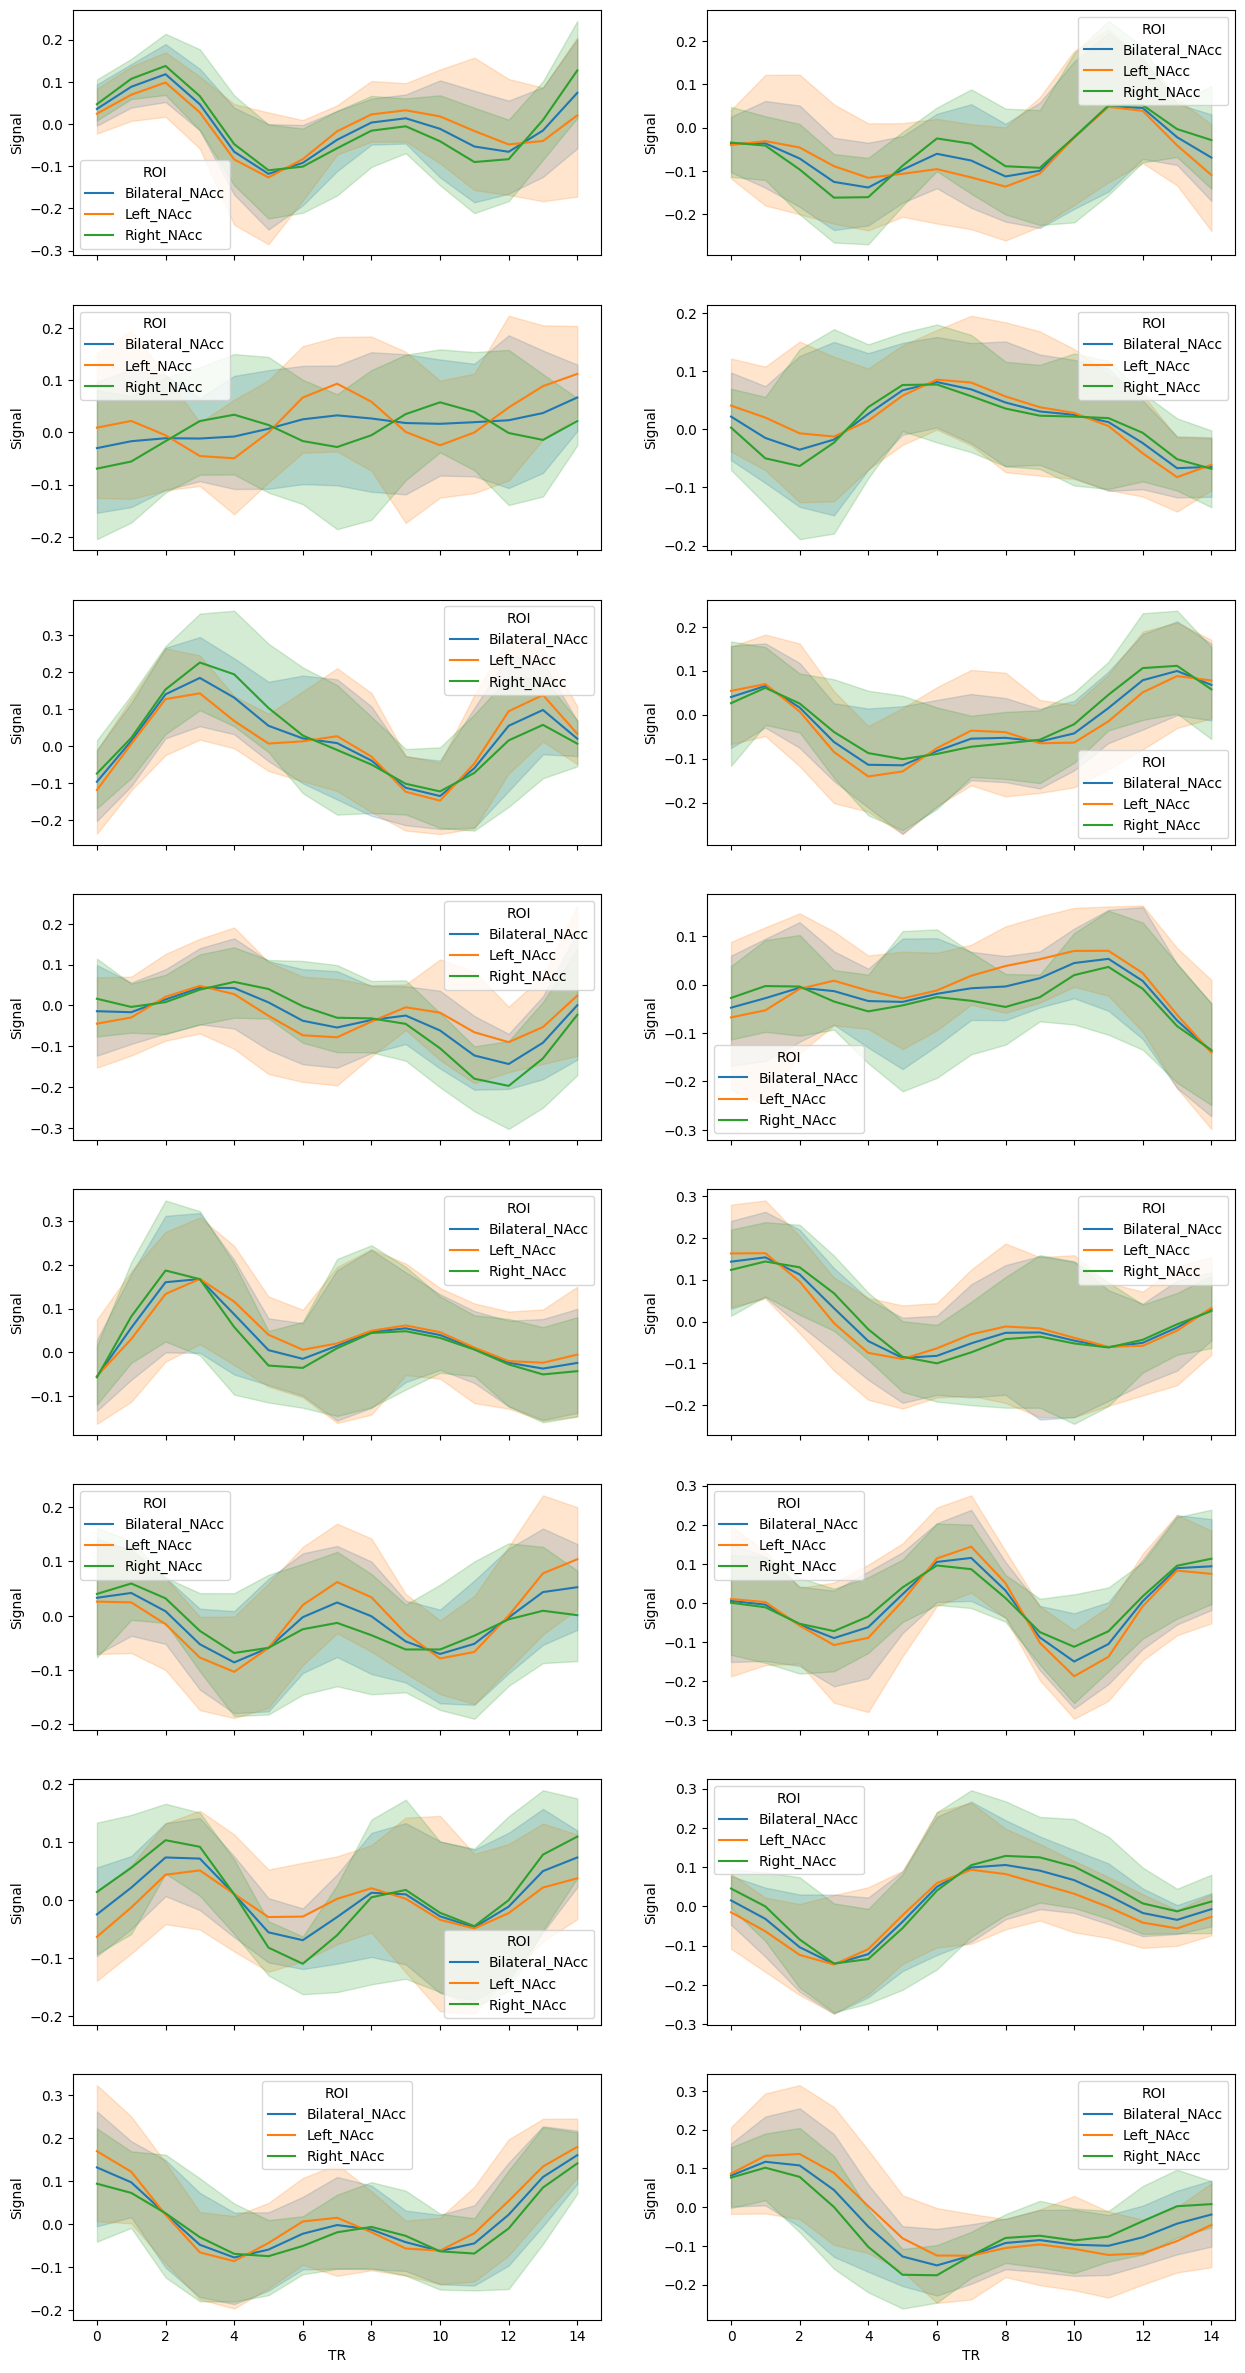

In [11]:
fig, axs = plt.subplots(8, 2, figsize=(15, 30), sharex=True)

runner = 0

for id in range(8):

    sns.lineplot(data=all_subjects_NAcc_timecourse_df[r1_keys_sorted[runner]], x="TR", y="Signal", hue="ROI", ax=axs[id, 0])

    runner +=1

    sns.lineplot(data=all_subjects_NAcc_timecourse_df[r1_keys_sorted[runner]], x="TR", y="Signal", hue="ROI", ax=axs[id, 1])

    runner +=1

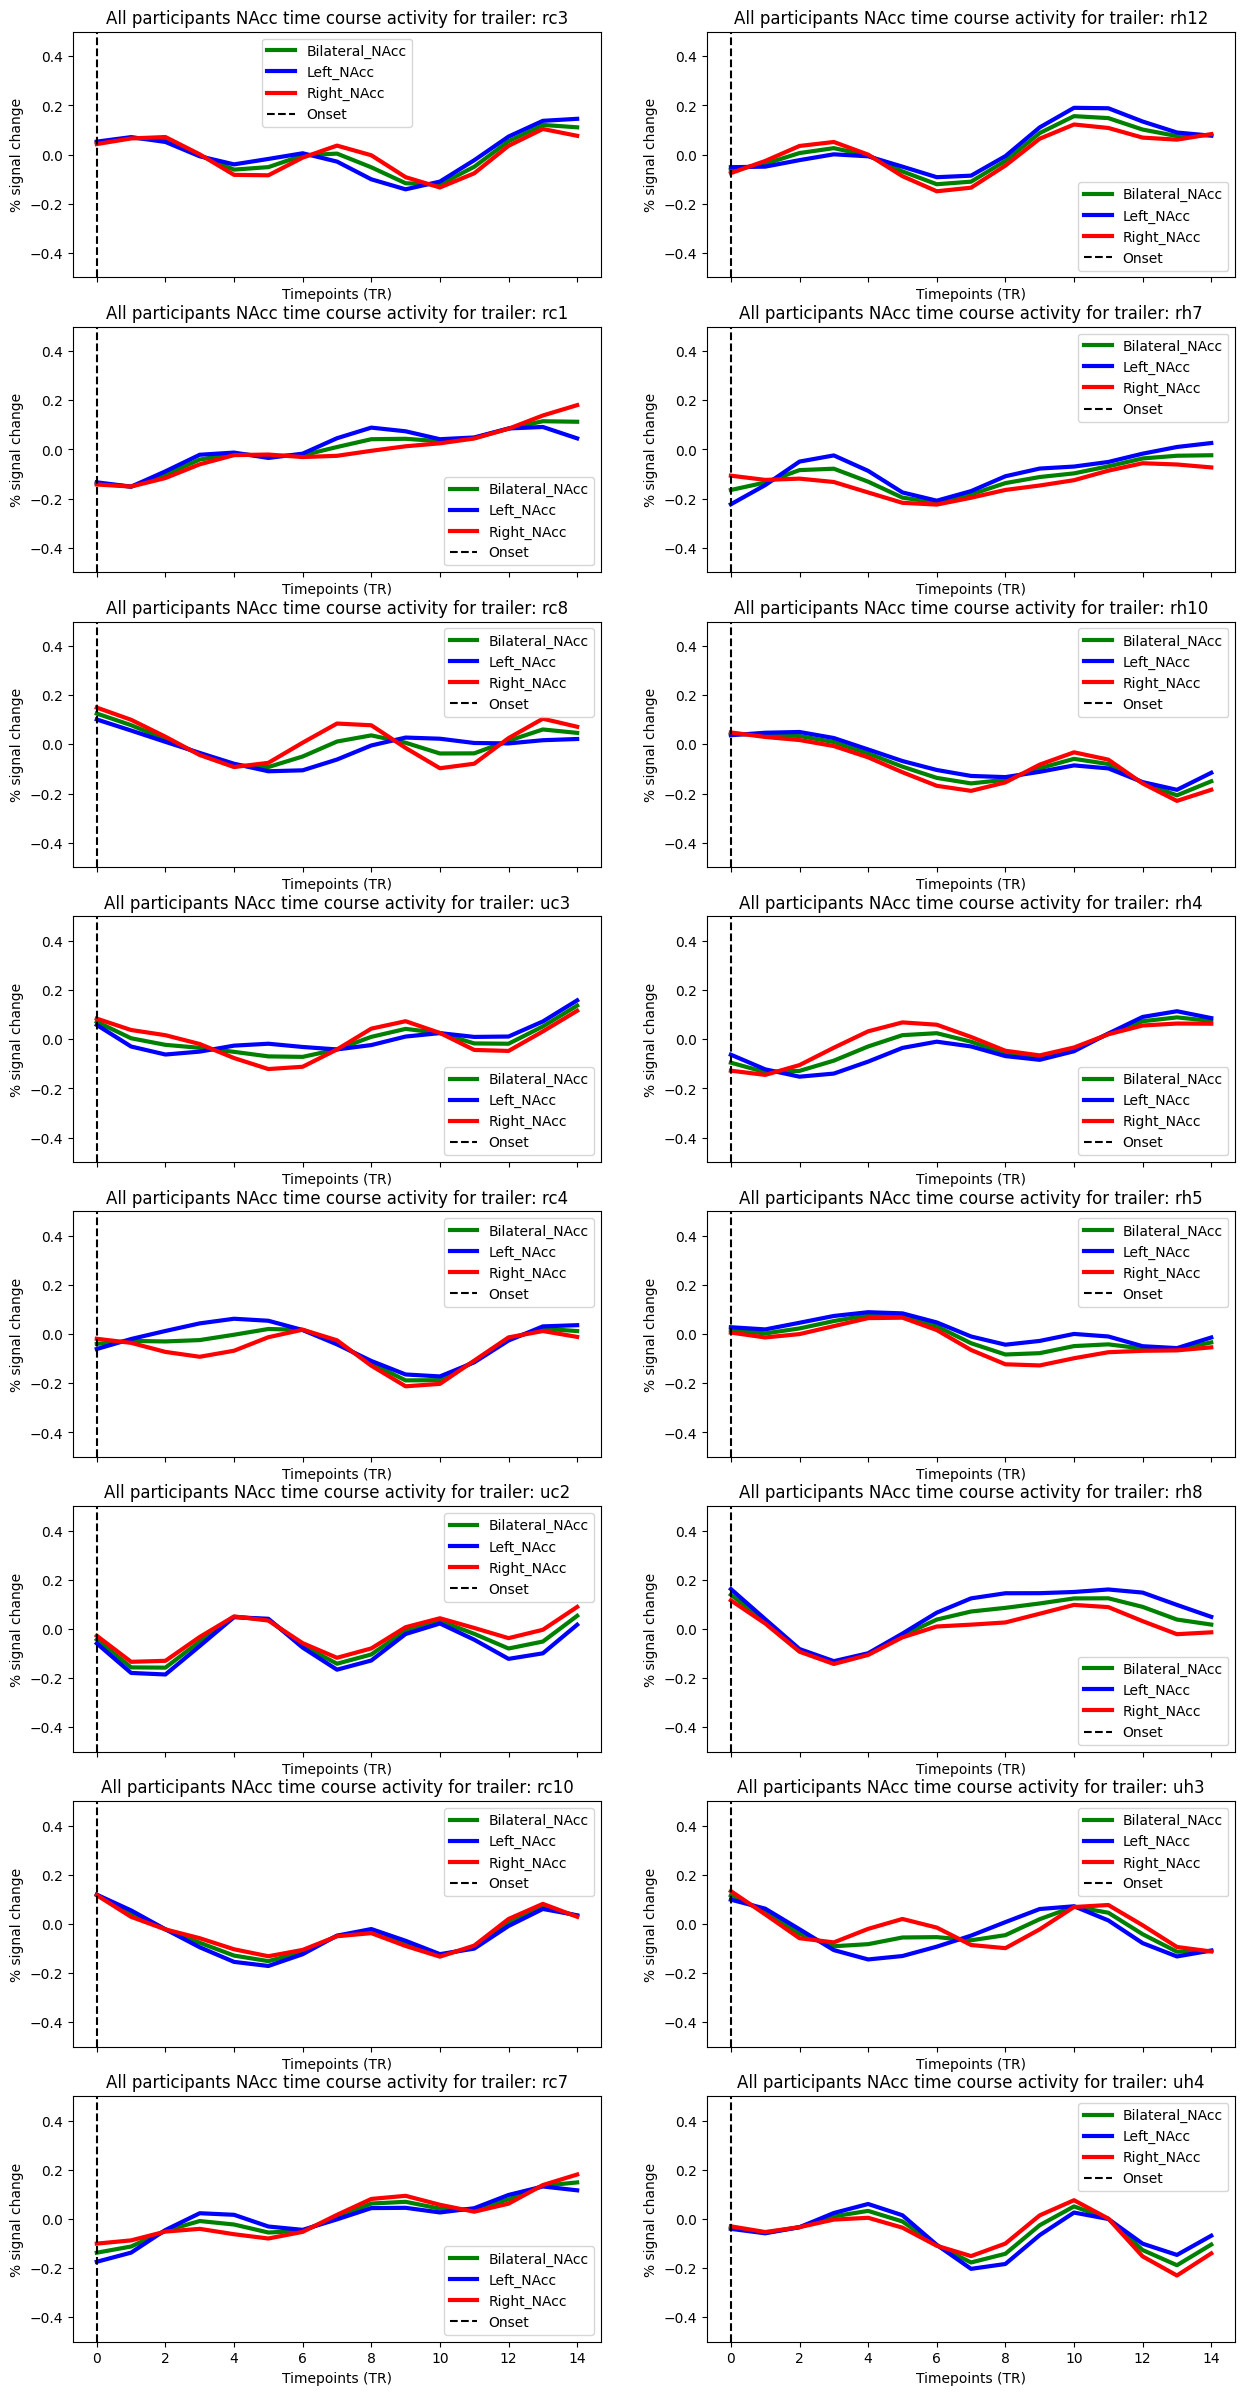

In [12]:
fig, axs = plt.subplots(8, 2, figsize=(15, 30), sharex=True)

runner = 0

for id in range(8):

    axs[id, 0].plot(all_subjects_avg_NAcc_timecourse[r2_keys_sorted[runner]]["Bilateral_NAcc"], 'g', lw=3, label="Bilateral_NAcc")
    axs[id, 0].plot(all_subjects_avg_NAcc_timecourse[r2_keys_sorted[runner]]["Left_NAcc"], 'b', lw=3, label="Left_NAcc")
    axs[id, 0].plot(all_subjects_avg_NAcc_timecourse[r2_keys_sorted[runner]]["Right_NAcc"], 'r', lw=3, label="Right_NAcc")
    axs[id, 0].axvline(x = 0, color = 'k', label ='Onset', linestyle='dashed')
    axs[id, 0].legend()
    axs[id, 0].set_ylabel('% signal change')
    axs[id, 0].set_xlabel('Timepoints (TR)')
    axs[id, 0].set_title("All participants NAcc time course activity for trailer: " + str(r2_keys_sorted[runner]))
    axs[id, 0].set_ylim(-.5, .5)

    runner +=1

    axs[id, 1].plot(all_subjects_avg_NAcc_timecourse[r2_keys_sorted[runner]]["Bilateral_NAcc"], 'g', lw=3, label="Bilateral_NAcc")
    axs[id, 1].plot(all_subjects_avg_NAcc_timecourse[r2_keys_sorted[runner]]["Left_NAcc"], 'b', lw=3, label="Left_NAcc")
    axs[id, 1].plot(all_subjects_avg_NAcc_timecourse[r2_keys_sorted[runner]]["Right_NAcc"], 'r', lw=3, label="Right_NAcc")
    axs[id, 1].axvline(x = 0, color = 'k', label ='Onset', linestyle='dashed')
    axs[id, 1].legend()
    axs[id, 1].set_ylabel('% signal change')
    axs[id, 1].set_xlabel('Timepoints (TR)')
    axs[id, 1].set_title("All participants NAcc time course activity for trailer: " + str(r2_keys_sorted[runner]))
    axs[id, 1].set_ylim(-.5, .5)

    runner +=1

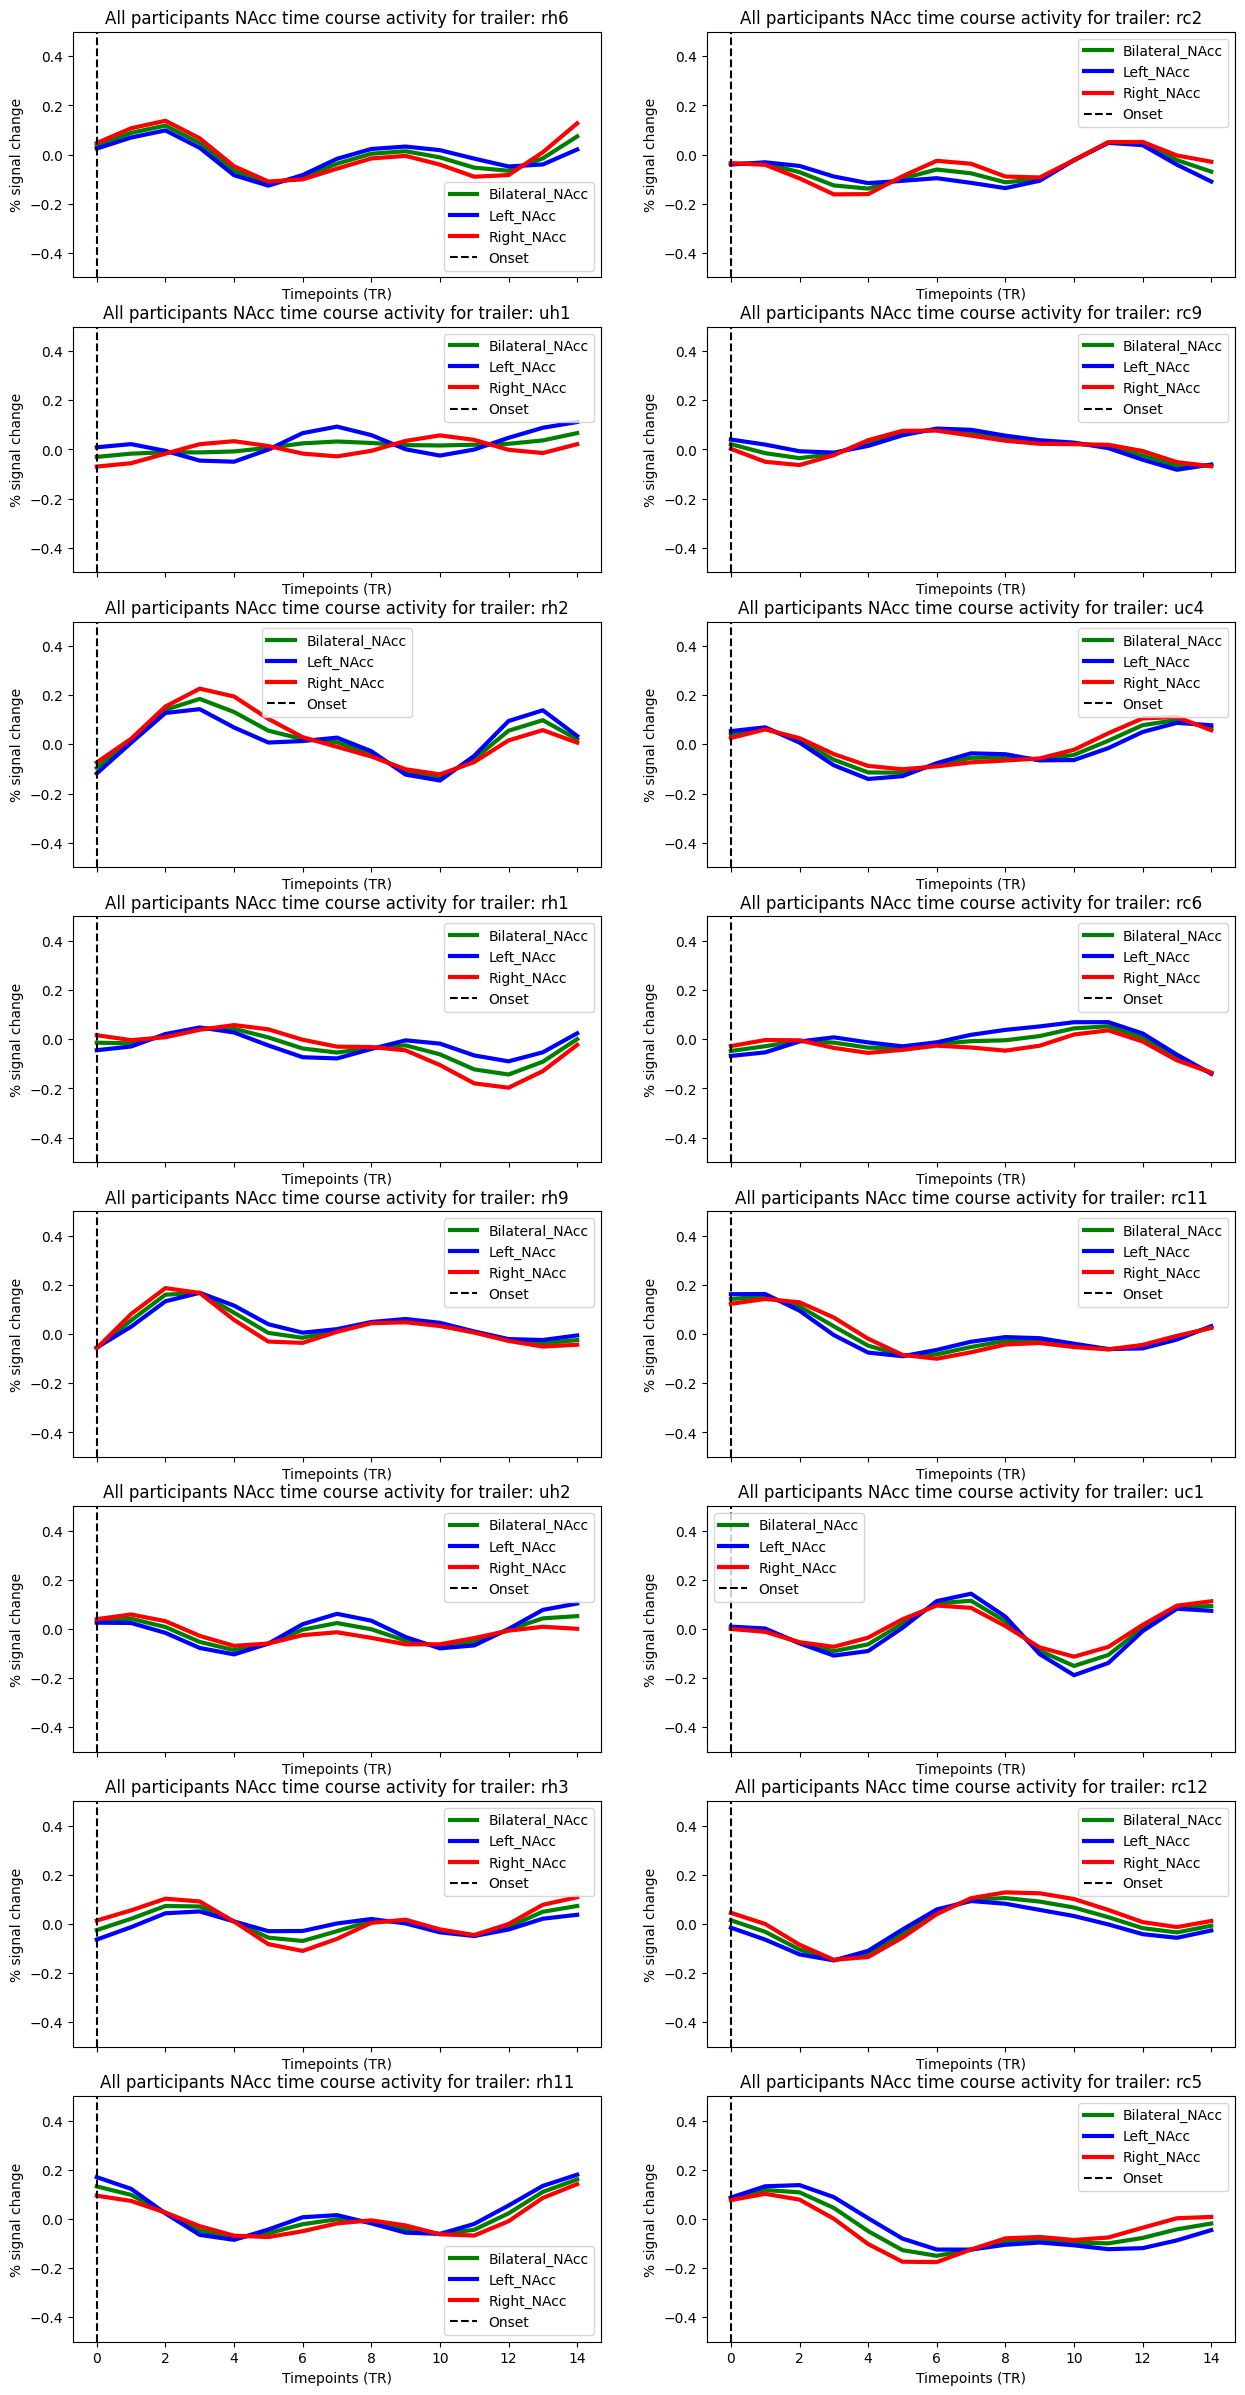

In [13]:
fig, axs = plt.subplots(8, 2, figsize=(15, 30), sharex=True)

runner = 0

for id in range(8):

    axs[id, 0].plot(all_subjects_avg_NAcc_timecourse[r1_keys_sorted[runner]]["Bilateral_NAcc"], 'g', lw=3, label="Bilateral_NAcc")
    axs[id, 0].plot(all_subjects_avg_NAcc_timecourse[r1_keys_sorted[runner]]["Left_NAcc"], 'b', lw=3, label="Left_NAcc")
    axs[id, 0].plot(all_subjects_avg_NAcc_timecourse[r1_keys_sorted[runner]]["Right_NAcc"], 'r', lw=3, label="Right_NAcc")
    axs[id, 0].axvline(x = 0, color = 'k', label ='Onset', linestyle='dashed')
    axs[id, 0].legend()
    axs[id, 0].set_ylabel('% signal change')
    axs[id, 0].set_xlabel('Timepoints (TR)')
    axs[id, 0].set_title("All participants NAcc time course activity for trailer: " + str(r1_keys_sorted[runner]))
    axs[id, 0].set_ylim(-.5, .5)

    runner +=1

    axs[id, 1].plot(all_subjects_avg_NAcc_timecourse[r1_keys_sorted[runner]]["Bilateral_NAcc"], 'g', lw=3, label="Bilateral_NAcc")
    axs[id, 1].plot(all_subjects_avg_NAcc_timecourse[r1_keys_sorted[runner]]["Left_NAcc"], 'b', lw=3, label="Left_NAcc")
    axs[id, 1].plot(all_subjects_avg_NAcc_timecourse[r1_keys_sorted[runner]]["Right_NAcc"], 'r', lw=3, label="Right_NAcc")
    axs[id, 1].axvline(x = 0, color = 'k', label ='Onset', linestyle='dashed')
    axs[id, 1].legend()
    axs[id, 1].set_ylabel('% signal change')
    axs[id, 1].set_xlabel('Timepoints (TR)')
    axs[id, 1].set_title("All participants NAcc time course activity for trailer: " + str(r1_keys_sorted[runner]))
    axs[id, 1].set_ylim(-.5, .5)

    runner +=1

KeyError: 'Bilateral_NAcc'

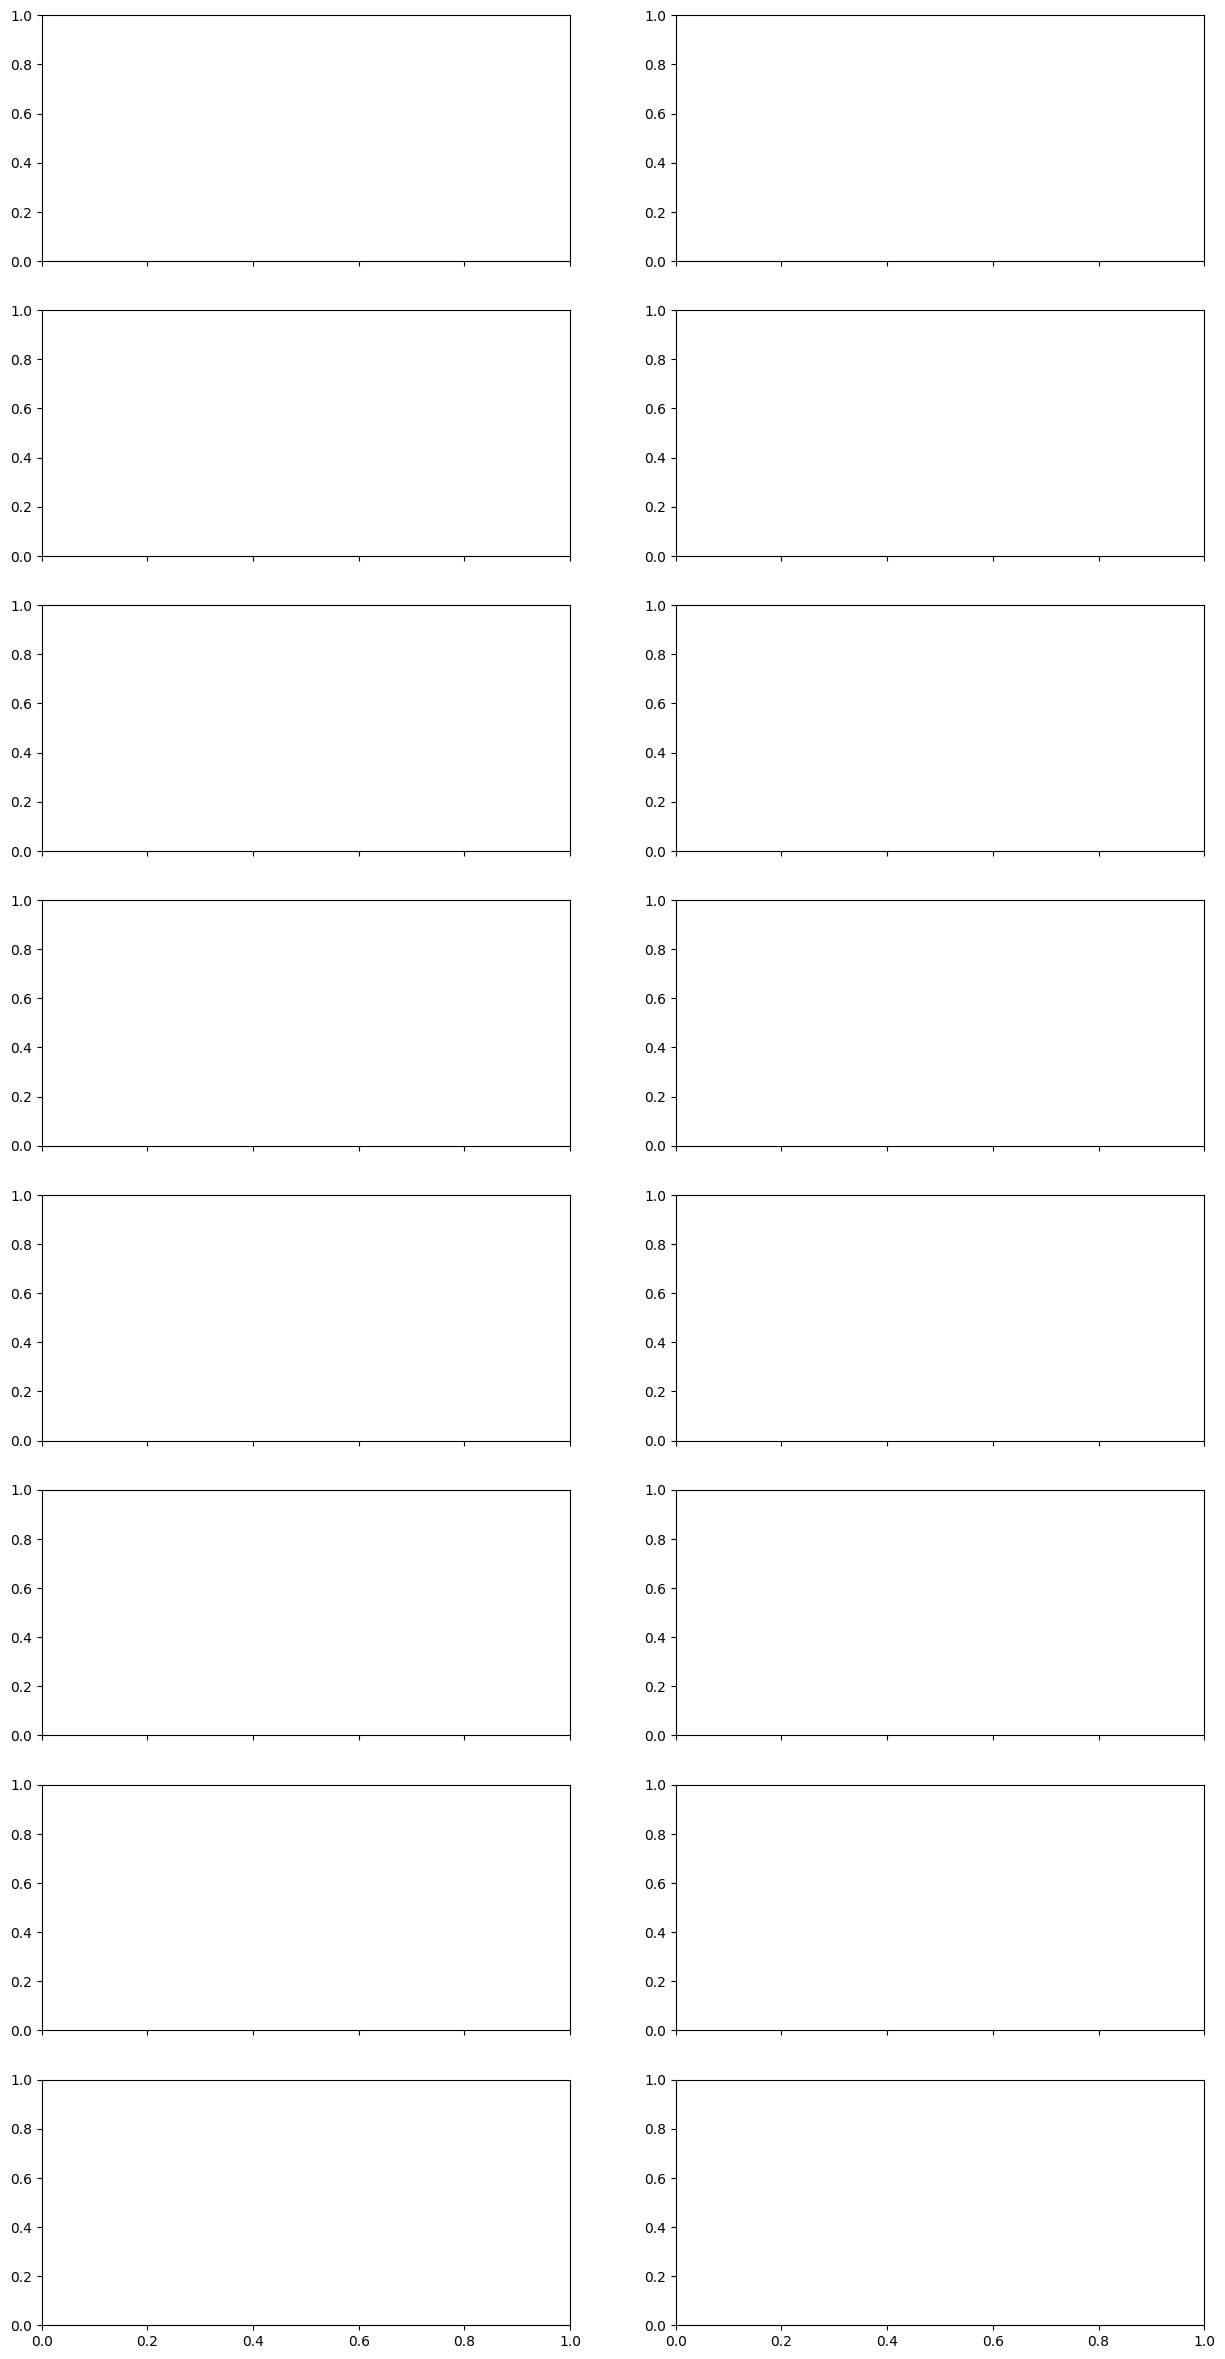

In [14]:
fig, axs = plt.subplots(8, 2, figsize=(15, 30), sharex=True)

runner = 0

for id in range(8):

    axs[id, 0].plot(all_subjects_NAcc_timecourse[r2_keys_sorted[runner]]["Bilateral_NAcc"], 'g', lw=3, label="Bilateral_NAcc")
    axs[id, 0].plot(all_subjects_NAcc_timecourse[r2_keys_sorted[runner]]["Left_NAcc"], 'b', lw=3, label="Left_NAcc")
    axs[id, 0].plot(all_subjects_NAcc_timecourse[r2_keys_sorted[runner]]["Right_NAcc"], 'r', lw=3, label="Right_NAcc")
    axs[id, 0].axvline(x = 0, color = 'k', label ='Onset', linestyle='dashed')
    axs[id, 0].legend()
    axs[id, 0].set_ylabel('% signal change')
    axs[id, 0].set_xlabel('Timepoints (TR)')
    axs[id, 0].set_title("All participants NAcc time course activity for trailer: " + str(r2_keys_sorted[runner]))
    axs[id, 0].set_ylim(-2, 2)

    runner +=1

    axs[id, 1].plot(all_subjects_NAcc_timecourse[r2_keys_sorted[runner]]["Bilateral_NAcc"], 'g', lw=3, label="Bilateral_NAcc")
    axs[id, 1].plot(all_subjects_NAcc_timecourse[r2_keys_sorted[runner]]["Left_NAcc"], 'b', lw=3, label="Left_NAcc")
    axs[id, 1].plot(all_subjects_NAcc_timecourse[r2_keys_sorted[runner]]["Right_NAcc"], 'r', lw=3, label="Right_NAcc")
    axs[id, 1].axvline(x = 0, color = 'k', label ='Onset', linestyle='dashed')
    axs[id, 1].legend()
    axs[id, 1].set_ylabel('% signal change')
    axs[id, 1].set_xlabel('Timepoints (TR)')
    axs[id, 1].set_title("All participants NAcc time course activity for trailer: " + str(r2_keys_sorted[runner]))
    axs[id, 1].set_ylim(-2, 2)

    runner +=1